In [1]:
#导入必要的包
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np

# 网络搭建

#### 下面的VGG16是fasterRcnn的基础网络部分，vgg16将分为两部分，前面的卷积层
#### 和后面的全连接层，分别用作fasterRCNN的特征提取和分类回归。
![jupyter](./img/ex.JPG)

In [2]:
#vgg16基础网络
def decom_vgg16():
    '''生成vgg16基础网络，并返回其卷积和全连接部分'''
    vgg = models.vgg16(pretrained=True, progress=True)
    #删去卷积最后的池化层
    extractor = nn.Sequential(*list(vgg.features)[:-1])
    classifier = vgg.classifier
    #删去全连接最后的线性层，为了定制输出
    del classifier[6]
    
    #冻结前4层的梯度，加快训练过程
    for i,layer in enumerate(extractor):
        if i>=10:
            break
        if isinstance(layer,torch.nn.modules.conv.Conv2d):
            for p in layer.parameters():
                p.requires_grad = False
    return extractor, classifier


#### 下面实现的是fasterRcnn的RPN部分，用作从激活层中提取前景目标。AnchorTargetCreator用于提供计算loss所需的真阳性信息
![jupyter](./img/rpn.JPG)

In [3]:
from lib.generate_anchors import enumerate_shifted_anchor
from lib.creator_tool import ProposalCreator
from lib.generate_anchors import generate_anchor_base,enumerate_shifted_anchor


def normal_init(m, mean, stddev, truncated=False):
    """
    权重初始化: 截断正态或随机正态.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

        
#RPN模块
class RegionProposalNetwork(nn.Module):
    """ Faster R-CNN中的区域提议网络（RPN）.

    参数:
        in_channels (int): 输入通道数.
        mid_channels (int): 中间层通道数.
        ratios (list of floats): 先验框宽高比列表
        anchor_scales (list of numbers): 先验框尺寸列表
        feat_stride (int): 特征图上移动一个像素对应于原图移动的像素

    """

    def __init__(self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32], feat_stride=16,
                 proposal_creator_params=dict(),
                ):
        
        super(RegionProposalNetwork, self).__init__()
        
        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        """RPN前向.

        参数:
            x (~torch.autograd.Variable): 传入的特征图(N, C, H, W)`.
            img_size (tuple of ints): 放缩之后的图像高宽(H,W)
            scale (float): 对比原图的放缩比例.

        返回:
            (~torch.autograd.Variable, ~torch.autograd.Variable, array, array, array):.

            * **rpn_locs**: 预测框的偏移缩放量，形状为(N, H*W*A, 4)`.
            * **rpn_scores**:预测框的分类置信度.形状为(N, H*W*A, 2)`.
            * **crois**: 输出所有的roi
            * **anchor**: 所有先验框的尺寸(H W A, 4)`.

        """
        n, _, hh, ww = x.shape
        #获取所有框，这一步需要动态获取，主要是因为输入的激活层尺寸不一。若能统一尺寸其实可以，在初始化
        #中获取所有框，这样还可以加快执行速度
        anchor = enumerate_shifted_anchor(self.anchor_base,self.feat_stride, hh, ww)

        n_anchor = anchor.shape[0] // (hh * ww)
        
        h = F.relu(self.conv1(x))
        rpn_locs = self.loc(h)
        # contiguous保持内存连续可以加快执行速度，reshape函数似乎可以更好地完成这个工作
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(
                rpn_locs[i].cpu().data.numpy(),
                rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size,
                scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)
            
        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        
        crois = np.zeros((rois.shape[0],rois.shape[1]+1),dtype=np.float32 )
        crois[:,0] = roi_indices
        crois[:,1:] = rois
        return rpn_locs, rpn_scores, crois, anchor
    



**下面实现了称之为RoIHead的模块，内容包括ROIpooling和目标类别的分类回归.**

**图中的PropasalTargetCreator在训练时向ROIloss提供真阳性信息，以及挑选部分数据，而不是全部，以加速训练**
![jupyter](./img/roihead.JPG)

In [4]:
from torchvision.ops import RoIAlign
from lib.array_tool import totensor


class VGG16RoIHead(nn.Module):
    """输出在RIOS上的分类和回归执信度.
    
    Args:
        n_class (int): 总类别数（包含背景）.
        roi_size (touple): RoI-pooling之后的roi尺寸.
        spatial_scale (float): roi的比例调整大小.将输入坐标映射到框坐标的缩放因子
        classifier (nn.Module): 从vgg16得来的两层线性层

    """

    def __init__(self, n_class, roi_size, spatial_scale,classifier):

        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4)
        self.score = nn.Linear(4096, n_class)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.n_class = n_class
        self.roi_size = roi_size
        self.spatial_scale = spatial_scale
        self.roi = RoIAlign(self.roi_size, self.spatial_scale, 1)

    def forward(self, x, rois):
        """
        假设输入batch有N个样本.

        参数:
            x (Variable): 4维图片(激活层).
            rois (Tensor): rois（N,5）

        """
        # in case roi_indices is  ndarray
        
        rois = totensor(rois).float()        
        pool = self.roi(x, rois)
        pool = pool.view(pool.size(0), -1)
        fc7 = self.classifier(pool)
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        return roi_cls_locs, roi_scores

from lib.creator_tool import AnchorTargetCreator
atc = AnchorTargetCreator()
bbox = np.array([[100,100,200,200],[200,200,300,500],[500,20,600,400]])
torch.manual_seed(2)
x = torch.rand(1,3,600,800)
print(x[0,1,1,:10])
extractor, classifier = decom_vgg16()
rpn = RegionProposalNetwork()
h = extractor(x)
rpn_locs, rpn_scores, crois, anchor = rpn(h,(600,800))

loc, label = atc(bbox,anchor,(600,800))
a = label.reshape(-1,450)
import matplotlib.pyplot as plt

img = np.zeros((37,50))
for j in range(37):
    for i in range(50):
        img[j,i] = max(a[j,i*9:i*9+9])
plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray')
plt.show()

print(np.sum(a==1))
print(np.sum(a==0))

from lib.creator_tool import ProposalTargetCreator
ptc = ProposalTargetCreator()

sroi, gt_loc, gt_label = ptc(crois,bbox,np.array([1,2,3]))

from lib.creator_tool import AnchorTargetCreator
atc = AnchorTargetCreator()
bbox = np.array([[100,100,200,200],[200,200,300,500],[500,20,600,400]])
torch.manual_seed(2)
x = torch.rand(1,3,600,800)
print(x[0,1,1,:10])
extractor, classifier = decom_vgg16()
rpn = RegionProposalNetwork()
h = extractor(x)
rpn_locs, rpn_scores, crois, anchor = rpn(h,(600,800))
head = VGG16RoIHead(21,(7,7),1/16,classifier)
roi_cls_locs, roi_scores = head(h,crois)
roi_cls_locs.size()

## Faster-Rcnn类的实现
**包装了构成fasterRcnn的必要组件。以及预测调用，产生优化器，学习率衰减等**

In [5]:
from torchvision.ops import nms
from lib.array_tool import totensor, tonumpy
from lib.bbox_tool import loc2bbox

def nograd(f):
    '''装饰器，使预测过程不追踪梯度'''
    def new_f(*args,**kwargs):
        with torch.no_grad():
           return f(*args,**kwargs)
    return new_f

class FasterRCNN(nn.Module):
    """Faster R-CNN基类.
    
    参数:
        extractor (nn.Module): 输入BCHW图片返回特征图的基础模型.
        rpn (nn.Module): RPN网络模型.
        head (nn.Module):输入BCHW变量的RoIs,返回回归和分类置信度的网络模型.
        loc_normalize_mean (tuple of four floats): 位置回归的均值估计.
        loc_normalize_std (tupler of four floats):位置回归的方差估计.

    """

    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)):
        
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.nms_thresh = 0.3
        self.score_thresh = 0.05

    @property
    def n_class(self):
        # 包括背景的分类总数.
        return self.head.n_class

    def forward(self, x, scale=1.):
        """Faster R-CNN前向.

        Args:
            x (autograd.Variable): 4D 图片变量.
            scale (float): 预处理时对原始图片的缩放.

        Returns:
            Variable, Variable, array, array:

            * **roi_cls_locs**: 所有roi的偏置缩放 (R', (L + 1) \\times 4)`.
            * **roi_scores**: 所有roi的分类预测 (R', L + 1)`.
            * **rois**: RPN提出的rois(R', 5)`.
        """
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, anchor = self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(h, rois)
        
        return roi_cls_locs, roi_scores, rois


    def _suppress(self, raw_cls_bbox, raw_prob):
        '''
        预测过程中执行的一系列操作，包括
            1.预测数据筛选，去除背景类
            2.执行极大值抑制，保留部分框
            3.数据的变形结合等
        
        参数：
            raw_cls_bbox(tensor):roihead给出的预测框回归（N,84）
            raw_prob（tensor）:roihead给出的分类执信(N,21)
        '''
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
        
            keep = nms(totensor(cls_bbox_l), totensor(prob_l), self.nms_thresh)
            keep = tonumpy(keep)
            bbox.append(cls_bbox_l[keep])
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep])
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

    @nograd
    def predict(self, imgs, sizes=None):
        """测试图片.

        This method predicts objects for each image.

        Args:
            imgs (可迭代的 numpy.ndarray): 保存着 CHW 结构 RGB 格式的图片像素值[0, 255]`.
            sizes（可迭代的列表/元组）：保存着每一张图片的高宽（H,W）
        Returns:
           tuple of lists:`(bboxes, labels, scores)`.

           * **bboxes**: `(y_{min}, x_{min}, y_{max}, x_{max})`
           * **labels** : [0, L - 1]
           * **scores** : (R,)

        """
        self.eval()
        prepared_imgs = imgs
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = totensor(rois[:,1:]) / scale

            # 将预测结果转换为图像上的坐标.
            # 预测框会放缩到输入图片的尺度
            mean = torch.Tensor(self.loc_normalize_mean).cuda().repeat(self.n_class)[None]
            std = torch.Tensor(self.loc_normalize_std).cuda().repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(tonumpy(roi).reshape((-1, 4)),tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[1])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[0])

            prob = tonumpy(F.softmax(totensor(roi_score), dim=1))

            raw_cls_bbox = tonumpy(cls_bbox)
            raw_prob = tonumpy(prob)

            bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)
            
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        """
        返回优化器
        """
        lr = 1e-3
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': 0.0005}]
                    
        self.optimizer = torch.optim.SGD(params, momentum=0.9)
        
        return self.optimizer

    def scale_lr(self, decay=0.1):
        """
        返回优化器
        """
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer

## 从Faster-Rcnn基类派生出基于VGG16的网络
**网络的整体结构如下图，其中AnchorTargetCreator和ProposalTargetCreator为训练时使用的额外模型，此处没有加入**
![jupyter](./img/all.jpg)

In [6]:
class FasterRCNNVGG16(FasterRCNN):
    """
    参数:
        n_fg_class (int): 不包括背景的分类类别数.
        ratios (list of floats): anchors的各种比例.
        anchor_scales (list of numbers): anchors的各种尺寸

    """

    feat_stride = 16  # 一共下采样了4次 1/2^4

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]
                 ):
                 
        extractor, classifier = decom_vgg16()

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=(7,7),
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )

        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )

rcnn = FasterRCNNVGG16()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import torch.utils.cpp_extension

## Faster-Rcnn训练器，用于训练faster-rcnn
**其中包含了训练时用到的AnchorTargetCreator, ProposalTargetCreator等部分**

In [7]:
from lib.creator_tool import AnchorTargetCreator, ProposalTargetCreator

class FasterRCNNTrainer(nn.Module):
    """方便训练的包装器. 返回所有的loss

    loss包括:

    * :obj:`rpn_loc_loss`: Region Proposal Network (RPN)网络的回归损失.
    * :obj:`rpn_cls_loss`: RPN的分类损失.
    * :obj:`roi_loc_loss`: roihead网络的回归损失.
    * :obj:`roi_cls_loss`: roihead网络的分类损失.
    * :obj:`total_loss`: 四个损失之和.

    Args:
        faster_rcnn (model.FasterRCNN):
            要训练的fasterrcnn模型.
    """

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = 3.0
        self.roi_sigma = 1.0

        # target creator create gt_bbox gt_label etc as training targets. 
        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()

    def forward(self, imgs, bboxes, labels, scale):
        """通过faster-rcnn计算loss.

        一些符号说明.

        * :math:`N` 是批图像数.
        * :math:`R` 是每张图的roi数量.

        当前, 只支持`N=1.

        Args:
            imgs (~torch.autograd.Variable): 图像变量（NCHW）‘N=1’.
            bboxes (~torch.autograd.Variable):真实框数据 (N, R, 4) `‘N=1’.
            labels (~torch.autograd..Variable):真实框的标签数据(N, R)`.不包含背景[0, L - 1]`
                                                `L` 是前景分类数
                                                
            scale (float): 对原始图片的缩放因子.

        Returns:
             5 个 loss
        """
        n = bboxes.shape[0]
        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        features = self.faster_rcnn.extractor(imgs)

        rpn_locs, rpn_scores, rois, anchor = self.faster_rcnn.rpn(features, img_size, scale)

        # 因为N=1，把批维度去掉方便操作
        bbox = bboxes[0]
        label = labels[0]
        rpn_score = rpn_scores[0]
        rpn_loc = rpn_locs[0]
        roi = rois

        # Sample RoIs and forward
        # it's fine to break the computation graph of rois, 
        # consider them as constant input
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi,
            tonumpy(bbox),
            tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)
        #因为ProposalTargetCreator的设计问题，此处需要插入一列idx
        sample_roi_index = np.zeros(len(sample_roi)) 
        sample_roi = np.insert(sample_roi, 0, values=sample_roi_index, axis=1)
        
        roi_cls_loc, roi_score = self.faster_rcnn.head(features, sample_roi)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(tonumpy(bbox), anchor, img_size)
        
        gt_rpn_label = totensor(gt_rpn_label).long()
        gt_rpn_loc = totensor(gt_rpn_loc)
        rpn_loc_loss = _fast_rcnn_loc_loss(
            rpn_loc,
            gt_rpn_loc,
            gt_rpn_label.data,
            self.rpn_sigma)

        # NOTE: default value of ignore_index is -100 ...
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.cuda(), ignore_index=-1)

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[torch.arange(0, n_sample).long().cuda(), totensor(gt_roi_label).long()]
        
        gt_roi_label = totensor(gt_roi_label).long()
        gt_roi_loc = totensor(gt_roi_loc)

        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label.data,
            self.roi_sigma)
        #迷惑行为
        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)]

        return losses
    
    def save(self, save_path):
        save_dict= self.faster_rcnn.state_dict()
        torch.save(save_dict, save_path)
        return save_path
    
    def load(self, path):
        state_dict = torch.load(path)
        return self
    
    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses[-1].backward()
        self.optimizer.step()

        return losses

def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()


def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

## 开始训练

In [8]:
from tqdm import tqdm
from torch.utils import data as data_
from lib.array_tool import scalar
from data.dataset import Dataset,TestDataset
from lib.eval_tool import eval_detection_voc

def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels = list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: 
            break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, use_07_metric=True)
    
    return result


def train(**kwargs):
    
    dataset = Dataset('/home/lch/pytorchstudy/data/VOC2012/')
    print('load data')
    dataloader = data_.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=8)
    
    testset = TestDataset('/home/lch/pytorchstudy/data/VOC2012/')
    test_dataloader = data_.DataLoader(testset,
                                       batch_size=1,
                                       num_workers=8,
                                       shuffle=False, \
                                       pin_memory=True
                                       )
    faster_rcnn = FasterRCNNVGG16()
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()

    best_map = 0
    lr_ = 1e-3
    running_loss = 0.
    for epoch in range(14):
        for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
            scale = scalar(scale)
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            losses = trainer.train_step(img, bbox, label, scale)
            
            running_loss += losses[-1].item()

            if (ii + 1) % 40 == 0:
                print('[%d, %5d] loss: %.3f' %(epoch + 1, ii + 1, running_loss / 40))
                running_loss = 0.0
                
        eval_result = eval(test_dataloader, faster_rcnn, test_num=10000)
        
        if eval_result['map'] > best_map:
            best_map = eval_result['map']
            best_path = trainer.save("./save/fasterRcnn.pth")
        print("epoch:",epoch,'map  :',eval_result['map'])
        if epoch == 9:
            trainer.faster_rcnn.scale_lr(0.1)
            lr_ = lr_ * 0.1

        if epoch == 13: 
            break

In [9]:
train()

load data


KeyboardInterrupt: 

# 可视化网络的训练结果

In [9]:
class_list = ['aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
                     ]

In [10]:
#一个可视化的函数

import matplotlib.patches as patches
def show_groundBox(image, classse = [], locations = []):
    if type(image) == type('./data'):
        image = plt.imread(image)
    colorList = ['b', 'g', 'r', 'c', 'm', 'y']
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for i,ele in enumerate(locations):
        if classse[i] == -1:
            break
        c = classse[i]%6
        rect = patches.Rectangle((ele[0],ele[1]),ele[2]-ele[0],ele[3]-ele[1],
                                 linewidth=2,edgecolor=colorList[c],facecolor='none')
        ax.add_patch(rect)
        ax.text(ele[0]+3, ele[1]-3, class_list[classse[i]],backgroundcolor = colorList[c],color = 'w')

In [11]:
testset = TestDataset('/home/lch/pytorchstudy/data/VOC2012/')
test_dataloader = data_.DataLoader(testset, batch_size=1, num_workers=8, shuffle=False, pin_memory=True)
faster_rcnn = FasterRCNNVGG16()
faster_rcnn.load_state_dict(torch.load("./save/fasterRcnn.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
faster_rcnn = faster_rcnn.cuda()

[375, 500]
[[ 51.015594  18.588135 473.91818  300.11084 ]]
[333, 500]
[[ 63.333153 186.0139    85.97637  245.15639 ]
 [ 33.720383  48.29225  490.94934  314.54803 ]]
[375, 500]
[[  0.       240.21243  423.43268  293.84586 ]
 [ 12.521881 124.669426 420.7006   288.02255 ]]
[375, 500]
[[463.5102  165.4163  500.      218.584  ]
 [218.56277 155.961   300.57486 222.50293]
 [359.707   164.29207 399.72012 199.69783]]
[375, 500]
[[ 91.69545   35.391663 380.0907   340.79755 ]]


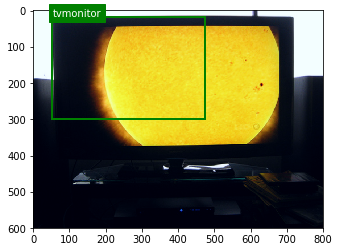

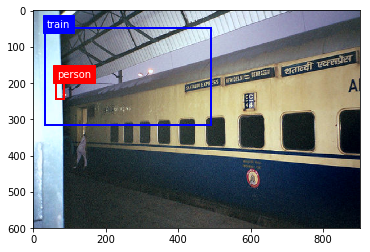

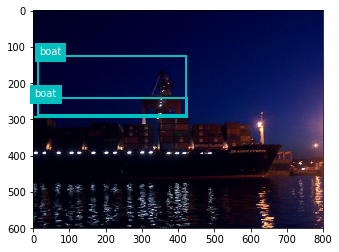

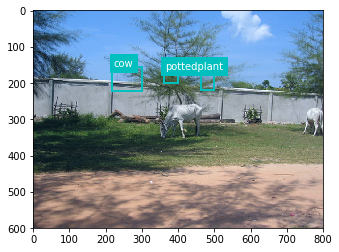

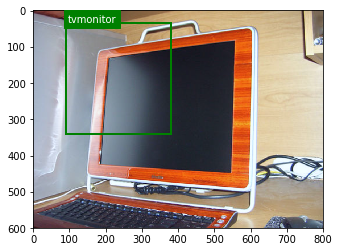

In [21]:
faster_rcnn.score_thresh = 0.7
import matplotlib.pyplot as plt
for ii, (imgs, sizes, gt_bboxes_, gt_labels_) in enumerate(test_dataloader):
    sizes = [sizes[0][0].item(), sizes[1][0].item()]
    print(sizes)
    pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
    img_show = imgs[0].numpy()
    img_show = (img_show * 0.225 + 0.45).clip(min=0, max=1).transpose((1,2,0))
    pred_bboxes_ = pred_bboxes_[0]
    pred_labels_ = pred_labels_[0]
    print(pred_bboxes_)
    show_groundBox(img_show,pred_labels_,pred_bboxes_)
    if ii > 3:
        break